# Fruits 360 fruits and vegetables classification
[Fruits 360 dataset](https://www.kaggle.com/moltean/fruits): A dataset of images containing fruits and vegetables by [Mihai Oltean](https://www.kaggle.com/moltean) includes below fruits and vegetables.

Apples (different varieties: Crimson Snow, Golden, Golden-Red, Granny Smith, Pink Lady, Red, Red Delicious), Apricot, Avocado, Avocado ripe, Banana (Yellow, Red, Lady Finger), Beetroot Red, Blueberry, Cactus fruit, Cantaloupe (2 varieties), Carambula, Cauliflower, Cherry (different varieties, Rainier), Cherry Wax (Yellow, Red, Black), Chestnut, Clementine, Cocos, Corn (with husk), Cucumber (ripened), Dates, Eggplant, Fig, Ginger Root, Granadilla, Grape (Blue, Pink, White (different varieties)), Grapefruit (Pink, White), Guava, Hazelnut, Huckleberry, Kiwi, Kaki, Kohlrabi, Kumsquats, Lemon (normal, Meyer), Lime, Lychee, Mandarine, Mango (Green, Red), Mangostan, Maracuja, Melon Piel de Sapo, Mulberry, Nectarine (Regular, Flat), Nut (Forest, Pecan), Onion (Red, White), Orange, Papaya, Passion fruit, Peach (different varieties), Pepino, Pear (different varieties, Abate, Forelle, Kaiser, Monster, Red, Stone, Williams), Pepper (Red, Green, Orange, Yellow), Physalis (normal, with Husk), Pineapple (normal, Mini), Pitahaya Red, Plum (different varieties), Pomegranate, Pomelo Sweetie, Potato (Red, Sweet, White), Quince, Rambutan, Raspberry, Redcurrant, Salak, Strawberry (normal, Wedge), Tamarillo, Tangelo, Tomato (different varieties, Maroon, Cherry Red, Yellow, not ripened, Heart), Walnut, Watermelon.

## Download dataset using kaggle cli

In [ ]:
#!kaggle datasets download moltean/fruits -p .data --unzip

## Import FastAI package

In [1]:
from fastai.vision.all import *

## EDA to verify data imbalance

In [2]:
fruits_path = Path('.data/fruits-360')
fruits_path.ls()

(#6) [Path('.data/fruits-360/test-multiple_fruits'),Path('.data/fruits-360/readme.md'),Path('.data/fruits-360/Training'),Path('.data/fruits-360/papers'),Path('.data/fruits-360/Test'),Path('.data/fruits-360/LICENSE')]

In [3]:
get_img_count = lambda path, ext:len([name for name in os.listdir(path) if name.endswith(ext)])

In [4]:
train_path = fruits_path/'Training'
fruits = [str(fruit.name) for fruit in list(train_path.ls())]
fruits_count = [get_img_count(path = train_path/fruit, ext='.jpg') for fruit in fruits]
max_imgs_per_class, min_imgs_per_class = max(fruits_count), min(fruits_count)
print (f'Fruit {fruits[fruits_count.index(max_imgs_per_class)]} has maximum ({max_imgs_per_class}) images')
print (f'Fruit {fruits[fruits_count.index(min_imgs_per_class)]} has maximum ({min_imgs_per_class}) images')

Fruit Grape Blue has maximum (984) images
Fruit Ginger Root has maximum (297) images


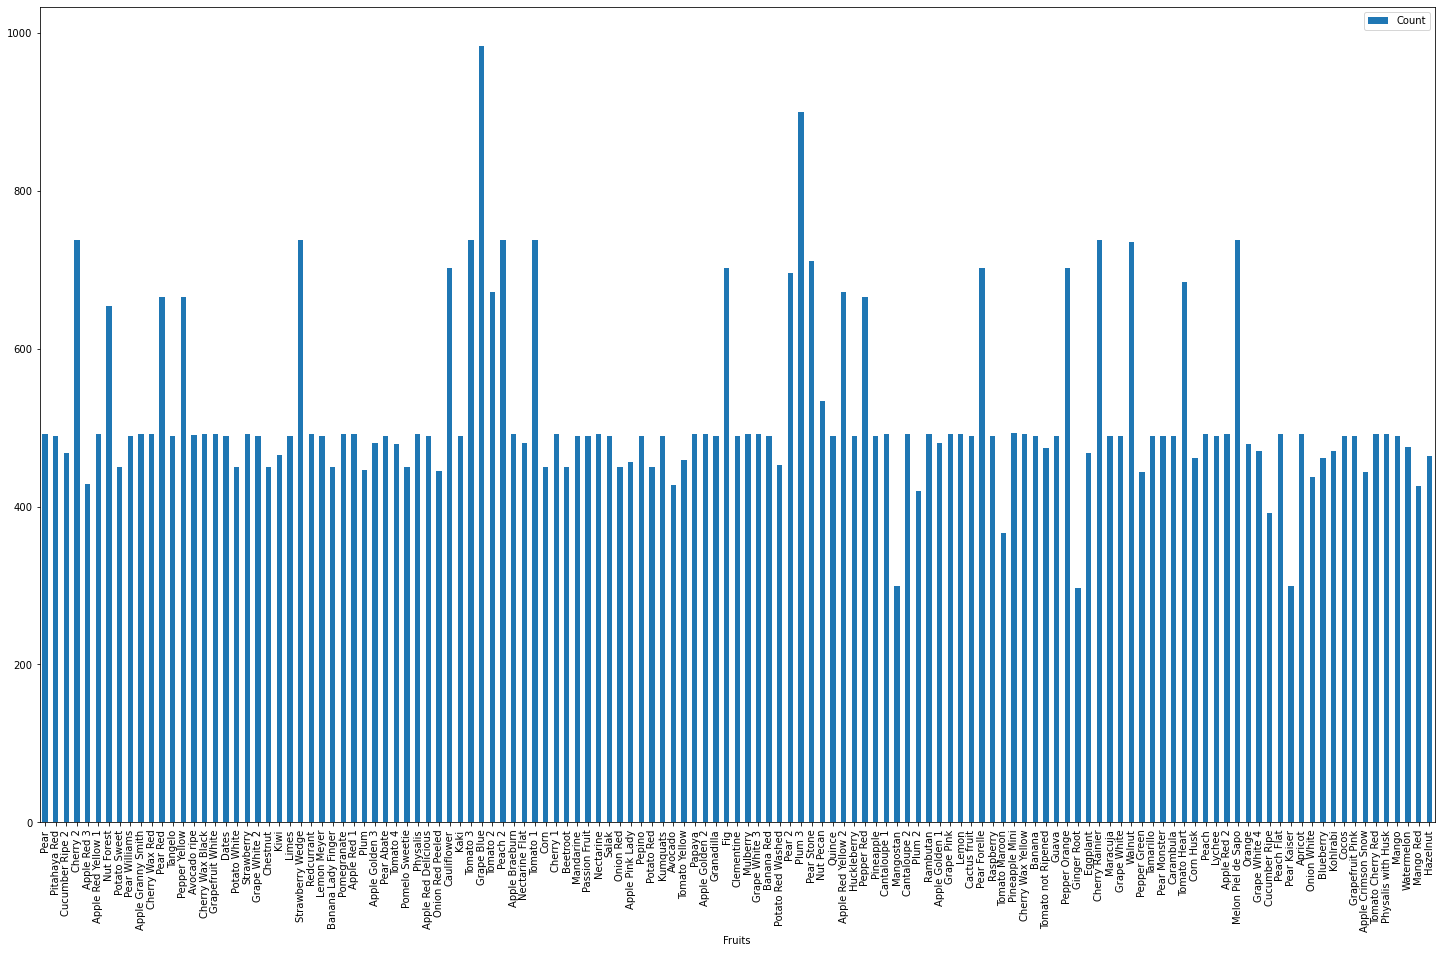

In [5]:
data = {'Fruits': fruits, 'Count': fruits_count}
df = pd.DataFrame.from_dict(data)
df.describe()
df.plot(kind='bar', x="Fruits", y="Count", figsize=(25, 15))

plt.show()

### Custom loss function (FocalLossFlat) to mitigate class imbalance issue

We can see Grape Blue has nearly 4 times of Ginger Root, there is class imbalnce, so we implemented FocalLoss function, which performs better than cross entropy during class imbalance.

In [6]:
from loss import FocalLossFlat

## Define dataloaders through DataBlock

In [7]:
def get_data(size=224, bs=64, path=fruits_path):
    fruits = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        get_items=get_image_files,
                        splitter=GrandparentSplitter(train_name='Training', valid_name='Test'),
                        get_y=parent_label,
                        item_tfms = Resize(size),
                        batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                    Normalize.from_stats(*imagenet_stats)]
                      )
    return fruits.dataloaders(fruits_path, bs=bs)


## Dataloaders with image size 64 and batch size 128

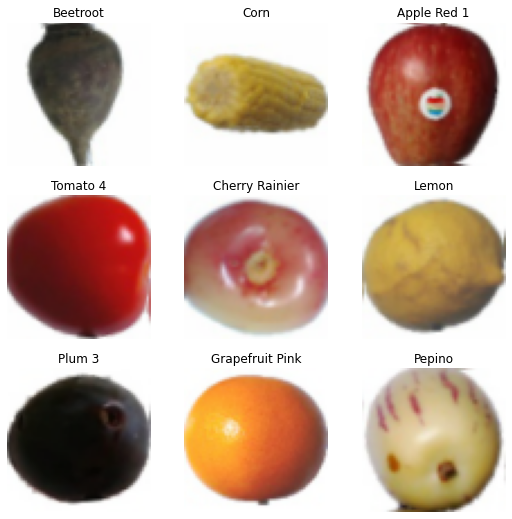

In [8]:
dls = get_data (64, 128)
dls.show_batch()

## Create learner with custom loss function

/home/gurucharan/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.015848932787775993)

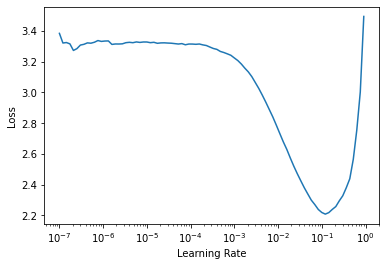

In [9]:
loss_func = FocalLossFlat()
learn = cnn_learner(dls, resnet34, loss_func=loss_func,metrics=[accuracy]).to_fp16()
learn.lr_find()

In [10]:
learn.fit_one_cycle(4, slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.171574,0.162005,0.920663,04:02
1,0.054084,0.068954,0.968794,01:02
2,0.014698,0.036388,0.980166,01:02
3,0.005675,0.024086,0.986953,01:01


## Dataloaders with image size 128 and batch size 64

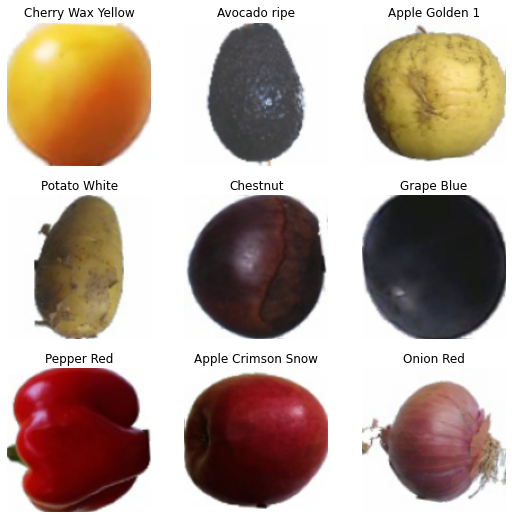

In [11]:
dls = get_data (128, 64)
dls.show_batch()
learn.dls = dls

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=1.0964781722577754e-06)

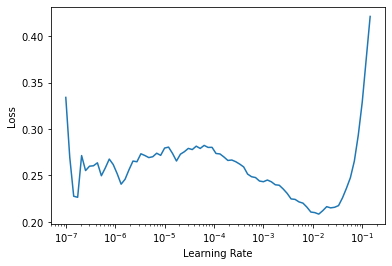

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(4, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.031138,0.023535,0.986733,02:24
1,0.010138,0.016452,0.990656,02:22
2,0.008520,0.012232,0.992331,02:24
3,0.008253,0.013370,0.992375,02:28


## Dataloaders with image size 256 and batch size 32

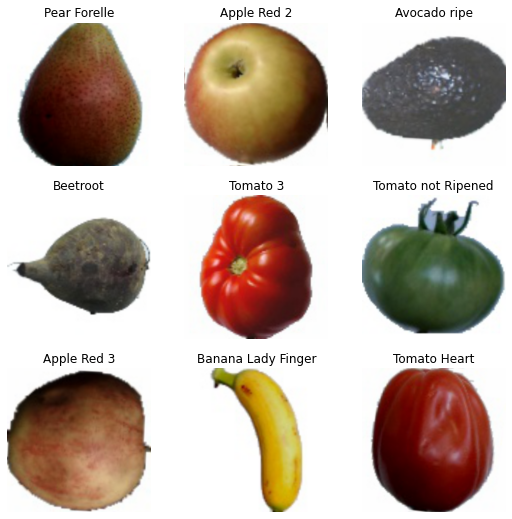

In [14]:
dls = get_data (256, 32)
dls.show_batch()
learn.dls = dls
learn.unfreeze()

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=2.2908675418875646e-06)

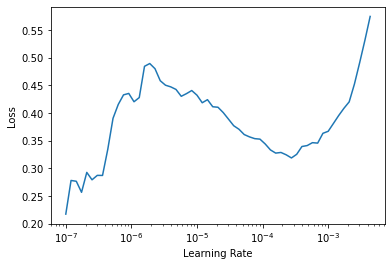

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(4, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.021931,0.014587,0.989554,09:44
1,0.009732,0.005767,0.996209,09:50
2,0.002973,0.006210,0.995945,10:02
3,0.004113,0.005725,0.996121,09:47


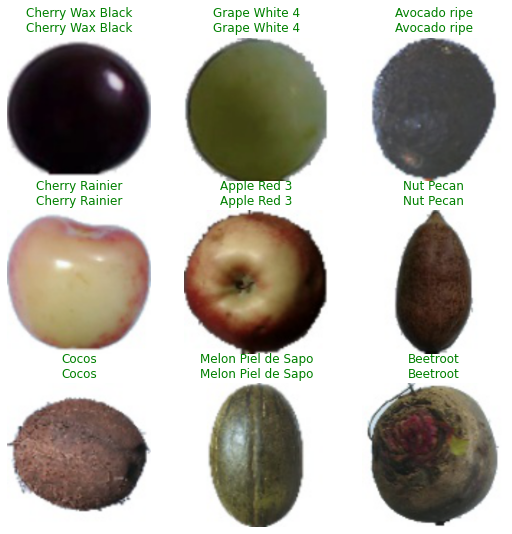

In [17]:
learn.show_results()